# <font color='blue'>**Cracking the Code: Regression Models with PyTorch**</font>

Ever wondered about the relationship between two variables, like how \( x \) impacts \( y \)? You might have a hunch about whether it’s linear or quadratic, but you're not 100% sure. That’s where this project comes in!

In this project, I'll be using **least mean squares regression** to nail down the coefficients for three models:

1. **Quadratic model**:  
    $y = b + w_1 \cdot x + w_2 \cdot x^2$
2. **Linear model** (with bias):  
   $y = b + w_1 \cdot x$
3. **Linear model** (without bias):  
   $y = w_1 \cdot x$

<font color='blue'>**Key approach**: I'm using Batch Gradient Descent to estimate the model coefficients. The idea here is to work with the entire dataset at each iteration.</font>  

Some important points to keep in mind:
- **No data splitting**: I’m sticking with just the training loop for now, so no need to worry about validation here.
- **Single training loop**: This means there’s only one `for loop` in the training process, looping over the entire dataset per epoch (no batch creation).
- **Experimentation is key**: I’ll be playing around with different epoch counts and learning rates to fine-tune the results.
- I’ll be leveraging **PyTorch’s nn.module and functions** to build out the models and handle the training.

Normally, neural networks wouldn’t be the go-to approach for problems like these, but I’m using this project as a way to sharpen my understanding of how regression works with PyTorch.

This project is a hands-on dive into basic regression techniques, giving me a solid foundation in how these models behave and how to tune them with PyTorch. Let’s see how well we can predict the relationship between \( x \) and \( y \)!



In [ ]:
import torch
import torch.nn as nn

## <font color = 'blue'> **Data**

In [ ]:
x = torch.tensor([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
y = torch.tensor([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])

## <font color='blue'>**Reshaping Tensors and forming the Quadratic Polynomial term**

- In PyTorch, the standard expected input shape for loss functions (such as MSELoss) is typically **(n, 1)**, where **n** represents the number of samples (observations) in the tensor.
- We can accomplish this reshaping using the `.reshape(-1, 1)` method. The **-1** allows PyTorch to automatically infer the correct number of rows based on the data's size, while **1** forces it into a single column.
- This is not exactly a transpose; it's more of a reshaping operation that changes the dimensions to match the expected input format for matrix operations.


In [ ]:
# Reshape the y tensor to have shape (n, 1), where n is the number of samples.
# This is done to match the expected input shape for PyTorch's loss functions.
y = y.reshape(-1,1)

# Reshape the x tensor to have shape (n, 1), similar to y, for consistency and to work with matrix operations.
x = x.reshape(-1,1)

# Compute the square of each element in x.
# This may be used for polynomial features in regression models.
x2 = x * x


In [ ]:
print('Tensor Y:\n\n', y)
print('-'*30)
print('Tensor X:\n\n', x)
print('-'*30)
print('Tensor X^2:\n\n',  x2)

Tensor Y:

 tensor([[ 63.8022],
        [ 80.0360],
        [ 91.4903],
        [108.2878],
        [122.7820],
        [161.3631],
        [166.5082],
        [176.1677],
        [180.2939],
        [179.0976],
        [206.2103],
        [272.7186],
        [272.2403],
        [289.5475],
        [293.8488],
        [295.2281],
        [306.6227],
        [327.9324],
        [383.1630],
        [408.6597]])
------------------------------
Tensor X:

 tensor([[1.5420],
        [1.8935],
        [2.1603],
        [2.5382],
        [2.8934],
        [3.8389],
        [3.9254],
        [4.2234],
        [4.2356],
        [4.2734],
        [4.9333],
        [6.4705],
        [6.5176],
        [6.8783],
        [7.0009],
        [7.0357],
        [7.2787],
        [7.7562],
        [9.1211],
        [9.7283]])
------------------------------
Tensor X^2:

 tensor([[ 2.3779],
        [ 3.5854],
        [ 4.6671],
        [ 6.4424],
        [ 8.3720],
        [14.7368],
        [15.4090],
     

In [ ]:
# Concatenate the original x tensor and its squared values (x2) along dimension 1 (columns).
# This creates a new tensor with two features: the original x and x2 (its square) . This can be useful for polynomial regression.

x_combined = torch.cat((x,x2),1)

x_combined


tensor([[ 1.5420,  2.3779],
        [ 1.8935,  3.5854],
        [ 2.1603,  4.6671],
        [ 2.5382,  6.4424],
        [ 2.8934,  8.3720],
        [ 3.8389, 14.7368],
        [ 3.9254, 15.4090],
        [ 4.2234, 17.8369],
        [ 4.2356, 17.9401],
        [ 4.2734, 18.2619],
        [ 4.9333, 24.3373],
        [ 6.4705, 41.8671],
        [ 6.5176, 42.4787],
        [ 6.8783, 47.3105],
        [ 7.0009, 49.0126],
        [ 7.0357, 49.5016],
        [ 7.2787, 52.9792],
        [ 7.7562, 60.1583],
        [ 9.1211, 83.1952],
        [ 9.7283, 94.6395]])

In [ ]:
print(x_combined.shape, x.shape)

torch.Size([20, 2]) torch.Size([20, 1])


## <font color = 'blue'>**Loss Function Initialization**
- We use a normal MSE loss function here with reduction='mean' to calculate the average MSE for different predicted target values

In [ ]:
loss_function = nn.MSELoss(reduction = 'mean')

## <font color = 'blue'> **Train Function**

In [ ]:
def train(epochs, x, y, loss_function, log_interval, model, optimizer):
    """
    Train a PyTorch model using gradient descent.

    Parameters:
    epochs (int): The number of training epochs.
    x (torch.Tensor): The input features.
    y (torch.Tensor): The ground truth labels.
    loss_function (torch.nn.Module): The loss function to be minimized.
    log_interval (int): The interval at which training information is logged.
    model (torch.nn.Module): The PyTorch model to be trained.
    optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.

    Side Effects:
    - Modifies the input model's internal parameters during training.
    - Outputs training log information at specified intervals.
    """
    losses = []

    for epoch in range(epochs):

        # Step 1: Forward pass - Compute predictions based on the input features
        y_hat = model(x)

        # Step 2: Compute Loss
        loss = loss_function(y_hat, y)

        # Step 3: Zero Gradients - Clear previous gradient information to prevent accumulation
        optimizer.zero_grad()

        # Step 4: Calculate Gradients - Backpropagate the error to compute gradients for each parameter
        loss.backward()

        # Step 5: Update Model Parameters - Adjust weights based on computed gradients
        optimizer.step()

        losses.append(loss.item())


        # Log training information at specified intervals
        if epoch % log_interval == 0:
            print(f'epoch: {epoch + 1} --> loss {loss.item()}')

    return losses[0:10] # First 10 losses for brevity

## **Part 1: Experimenting with Learning Rates and Model Initialization**

- In this part, I'm using `x_combined` (including both $x$ and $x^2$) as inputs to the model. This gives us two inputs for the model.
- I'm defining the model using the `nn.linear` function. <font color = 'blue'>**It's important to carefully think through the values for the three arguments `in_features`, `out_features`, and `bias`.**</font> Each choice here impacts how the model behaves.
- By default, PyTorch’s `nn.Linear` layer uses Kaiming initialization for weights, which works great with ReLU activations. However, in this experiment, <font color = 'blue'>**I’m explicitly overriding the default with custom initialization**</font> using `nn.init.normal_` for weights and `nn.init.zeros_` for bias.

**<font color = 'blue'>**Now for the experiments...**</font>**

### First attempt: LEARNING_RATE = 0.05
I ran the model with a learning rate of 0.05. Here’s what I noticed:

- <font color = 'blue'>**When using the higher learning rate, it is clear we are overshooting**</font> the optimal target because the loss value increases to a nan value.
- Numerically, just like with exponential calculations, our learning rate is pushing the loss to an overflow point that the computer cannot handle.
- This is why we should not use 0.05 to calculate our loss because the nan value happens even before the second log of the training EPOCHS.

### Second attempt: LEARNING_RATE = 0.0005
This time, I dialed it down to a learning rate of 0.0005. Here’s what I observed:

- When using this smaller learning rate, we can see that the loss starts off very high, but <font color = 'blue'>**at the first log of the 10001 iteration**</font>, the loss has sharply decreased and is not nan as it was with the higher learning rate.
- As the model continues training, we can see in the logs that the loss incrementally decreases during the rest of the training process.
- <font color = 'blue'>**This means our learning rate is stably calculating loss**</font>, and our SGD process is functioning properly.


In [ ]:
# Model 1: 1st Attempt
LEARNING_RATE = 0.05
EPOCHS = 100000
LOG_INTERVAL = 10000

# Define a linear model with 2 inputs, 1 output, and bias
model = nn.Linear(in_features=2, out_features=1, bias=True)

# Initialize weights with a normal distribution (mean=0, std=0.01)
nn.init.normal_(model.weight, mean=0, std=0.01)

# Set bias terms to zero
nn.init.zeros_(model.bias)

# Create SGD optimizer with the set learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the model with the specified settings
train(EPOCHS, x_combined, y, loss_function, LOG_INTERVAL, model, optimizer)


epoch: 1 --> loss 57972.03125
epoch: 10001 --> loss nan
epoch: 20001 --> loss nan
epoch: 30001 --> loss nan
epoch: 40001 --> loss nan
epoch: 50001 --> loss nan
epoch: 60001 --> loss nan
epoch: 70001 --> loss nan
epoch: 80001 --> loss nan
epoch: 90001 --> loss nan


[57972.03125,
 1705461504.0,
 53872567517184.0,
 1.7017432833670513e+18,
 5.375519033227561e+22,
 1.698035483344887e+27,
 5.3638065649363485e+31,
 1.6943357709247003e+36,
 inf,
 inf]

epoch: 1 --> loss 57684.1953125
epoch: 10001 --> loss 5.004489898681641
epoch: 20001 --> loss 3.0957753658294678
epoch: 30001 --> loss 2.1380200386047363
epoch: 40001 --> loss 1.6573976278305054
epoch: 50001 --> loss 1.4162005186080933
epoch: 60001 --> loss 1.2950108051300049
epoch: 70001 --> loss 1.2341464757919312
epoch: 80001 --> loss 1.2036068439483643
epoch: 90001 --> loss 1.1882133483886719


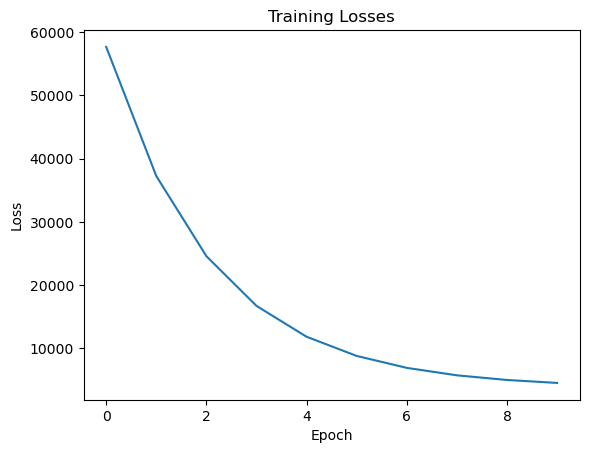

In [ ]:
# Model 1: 2nd Attempt
import matplotlib.pyplot as plt

LEARNING_RATE = 0.0005
EPOCHS = 100000
LOG_INTERVAL = 10000

# Define the model with 2 inputs, 1 output, and bias
model = nn.Linear(in_features=2, out_features=1, bias=True)

# Initialize weights (mean=0, std=0.01)
nn.init.normal_(model.weight, mean=0, std=0.01)

# Set bias to zero
nn.init.zeros_(model.bias)

# Create SGD optimizer with specified learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the model and track losses
losses = train(EPOCHS, x_combined, y, loss_function, LOG_INTERVAL, model, optimizer)

# Plot the training losses
plt.plot(losses)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
print(f' Weights {model.weight.data}, \nBias: {model.bias.data}')

 Weights tensor([[4.1796e+01, 1.4829e-02]]), 
Bias: tensor([0.9775])


## <font color = 'blue'>**Part 2: Single Input, Simpler Model**

- <font color = 'blue'>**For Part 2, we’re only using $x$ as the input, so there's just one input this time.**</font>
- I’ll define the model using `nn.Linear`. <font color = 'blue'>**Pay attention to how I set the `in_features`, `out_features`, and `bias` arguments.**</font>

## <font color = 'blue'>**Observations**</font>
- With a learning rate of 0.01, we take bigger steps toward minimizing the loss.
- It’s a quicker way to reach the solution with less computation compared to the earlier model. Fewer features mean fewer calculations, and we’re getting closer to the optimal solution with fewer EPOCHS.


epoch: 1 --> loss 58043.36328125
epoch: 11 --> loss 6.982641696929932
epoch: 21 --> loss 6.607934474945068
epoch: 31 --> loss 6.2574591636657715
epoch: 41 --> loss 5.929598331451416
epoch: 51 --> loss 5.6228203773498535
epoch: 61 --> loss 5.335864067077637
epoch: 71 --> loss 5.067376136779785
epoch: 81 --> loss 4.816222667694092
epoch: 91 --> loss 4.581284523010254
epoch: 101 --> loss 4.3614726066589355
epoch: 111 --> loss 4.155834674835205
epoch: 121 --> loss 3.963468551635742
epoch: 131 --> loss 3.7835001945495605
epoch: 141 --> loss 3.6151580810546875
epoch: 151 --> loss 3.4576549530029297
epoch: 161 --> loss 3.3102803230285645
epoch: 171 --> loss 3.1724371910095215
epoch: 181 --> loss 3.043503999710083
epoch: 191 --> loss 2.9228453636169434
epoch: 201 --> loss 2.8100078105926514
epoch: 211 --> loss 2.7044012546539307
epoch: 221 --> loss 2.605621576309204
epoch: 231 --> loss 2.513223171234131
epoch: 241 --> loss 2.4267821311950684
epoch: 251 --> loss 2.34591007232666
epoch: 261 --> 

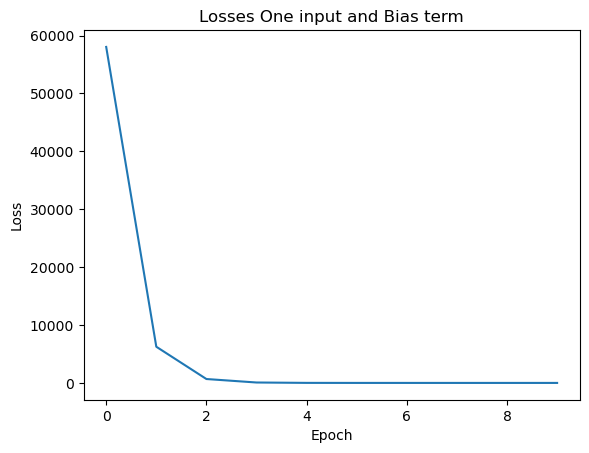

In [ ]:
# Model 2 setup
LEARNING_RATE = 0.01
EPOCHS = 1000
LOG_INTERVAL = 10

# Define the model with 1 input, 1 output, and bias
model = nn.Linear(in_features=1, out_features=1, bias=True)

# Initialize weights (mean=0.0, std=0.1)
nn.init.normal_(model.weight, mean=0.0, std=0.1)

# Set bias to zero
nn.init.zeros_(model.bias)

# Create an SGD optimizer with the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the model using x as input
losses_one_input = train(EPOCHS, x, y, loss_function, LOG_INTERVAL, model, optimizer)

plt.plot(losses_one_input)
plt.title('Losses One input and Bias term')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
print(f' Weights {model.weight.data}, \nBias: {model.bias.data}')

 Weights tensor([[41.9377]]), 
Bias: tensor([0.7469])


## <font color = 'blue'>**Part 3: No Bias Term**

- <font color = 'blue'>**Part 3 is similar to Part 2, but now the model has no bias term.**</font>
- **We’re running the model for just 10 epochs and will still get similar results.**

## <font color = 'blue'>**Observations**</font>
- Now we can see that when we do not include a bias term, we get similar results to the last model, but only running 10 EPOCHS.
- This could be because we are running fewer calculations since there are fewer parameters, resulting in faster convergence.
- The prediction line is running through the origin, which suggests the bias term doesn’t have a significant impact on the results.
- If the chart doesn't clearly show the difference in EPOCH training below make sure to look at the loss value for the 11th EPOCH in part two and notice that we are getting a better convergence here after only <font color = 'blue'>**6 EPOCHS**.


epoch: 1 --> loss 58319.1953125
epoch: 2 --> loss 6938.1240234375
epoch: 3 --> loss 826.3634033203125
epoch: 4 --> loss 99.3714370727539
epoch: 5 --> loss 12.89579963684082
epoch: 6 --> loss 2.6095829010009766
epoch: 7 --> loss 1.3860321044921875
epoch: 8 --> loss 1.2404857873916626
epoch: 9 --> loss 1.223174810409546
epoch: 10 --> loss 1.221120834350586


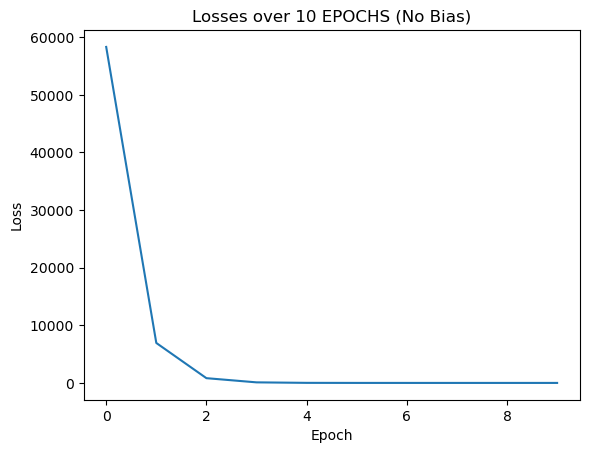

In [ ]:
# Model 3 setup (No bias term)
LEARNING_RATE = 0.01
EPOCHS = 10
LOG_INTERVAL = 1

# Define the model with 1 input, 1 output, and no bias
model = nn.Linear(in_features=1, out_features=1, bias=False)

# Initialize weights (mean=0.0, std=1.0)
nn.init.normal_(model.weight, mean=0.0, std=1.0)

# No need to initialize the bias since there's no bias term

# Create SGD optimizer with the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the model and track losses
losses_no_bias = train(EPOCHS, x, y, loss_function, LOG_INTERVAL, model, optimizer)

# Plot the training losses
plt.plot(losses_no_bias)
plt.title('Losses over 10 EPOCHS (No Bias)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
print(f' Weights {model.weight.data}')

 Weights tensor([[42.0557]])
